# Forest Cover Prediction
## by: Avengers End Game
### authors: Naga Chandrasekaran, Scott Gatzemeier Aidan Jackson, and Andi Morey Peterson 

### Executive Summary

The goal of this project is to classify trees in four different wilderness areas of the Roosevelt National Forest in Northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.  Accurate results of a successful model will allow US Forest Service (USFS) to predict the predominant cover type trees to plant in reforestation efforts of the 800,000 acres in the Roosevelt National Forest.

![Picture Credit to: alchetron.com](https://i.ytimg.com/vi/Yi4ICw5L4h0/maxresdefault.jpg)

The data was collected by the USFS and the US Geological Survey and provided to Kaggle by Colorado State University.  Each entry of the dataset represents a 30x30 meter cell.  The project will attempt to predict one of seven cover types using features such as elevation, slope, soil type, wilderness areas, aspect, and distance measures.


#### Table of Contents:

1) Exploratory Data Analysis

2) Clean/Format Data and Feature Engineering

3) Initial Machine Learning Models

4) Hyperparameter Tuning

5) Evaluatation the Best Model

6) Interpret Model Results

7) Summary & Conclusions

### Exploratory Data Analysis

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import time
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

np.random.seed(0)

raw_data = pd.read_csv(r"data/covtype.csv") #https://www.kaggle.com/uciml/forest-cover-type-dataset
train_df = pd.read_csv(r"data/train.csv") #https://www.kaggle.com/c/forest-cover-type-prediction/data
test_df = pd.read_csv(r"data/test.csv") #https://www.kaggle.com/c/forest-cover-type-prediction/data


*Note on data sourcing*:  The data used for this project comes from Kaggle. The ["Raw" Data Set](https://www.kaggle.com/uciml/forest-cover-type-dataset) consists of both the train and test data sets and is labeled, however does not have ID's in which to identify each entry.  For the purposes of this project, the raw dataset will only be used for EDA but not used in model building. The train and test datasets [(found here)](https://www.kaggle.com/c/forest-cover-type-prediction/data) are used as such in all future models.

In [2]:
#Read data for analysis
print('Data Dimensions for Raw Data:')
print('   Number of Records:', raw_data.shape[0])
print('   Number of Features:', raw_data.shape[1])
print('Data Dimensions for Train Data:')
print('   Number of Records:', train_df.shape[0])
print('   Number of Features:', train_df.shape[1])
print('Data Dimensions for Test Data:')
print('   Number of Records:', test_df.shape[0])
print('   Number of Features:', test_df.shape[1])
print('Feature Names:')
print(raw_data.columns)

Data Dimensions for Raw Data:
   Number of Records: 581012
   Number of Features: 55
Data Dimensions for Train Data:
   Number of Records: 15120
   Number of Features: 56
Data Dimensions for Test Data:
   Number of Records: 565892
   Number of Features: 55
Feature Names:
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Ty

#### Feature Information:

The seven cover types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

First, the distribution will tell if there is skewness in the predictions we are trying to replicate.

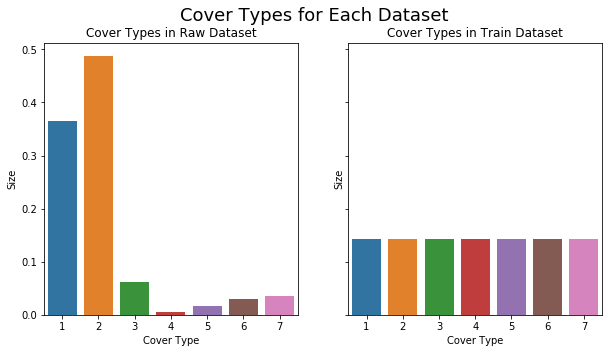

In [3]:
#Plot distribution of cover types
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

ax[0].set(ylabel='Percentage of Data')

class_dist=raw_data.groupby('Cover_Type').size()/raw_data.shape[0]
class_label=pd.DataFrame(class_dist,columns=['Size'])
sns.barplot(ax=ax[0],x=class_label.index,y='Size',data=class_label)
ax[0].set_title("Cover Types in Raw Dataset")
ax[0].set(xlabel='Cover Type')

class_dist=train_df.groupby('Cover_Type').size()/train_df.shape[0]
class_label=pd.DataFrame(class_dist,columns=['Size'])
sns.barplot(ax=ax[1],x=class_label.index,y='Size',data=class_label)
ax[1].set_title("Cover Types in Train Dataset")
ax[1].set(xlabel='Cover Type')

plt.suptitle('Cover Types for Each Dataset', fontsize=18)
plt.show()

The train data set that we will use for the model building is evenly distributed, but the raw dataset has skewness that we should be aware of and will contribute to overfitting of the train data.

#### Feature Information (cont):

The rest of the data that we can use as features for models are as follows:

- Elevation (continuous) - Elevation in meters
- Aspect (continuous) - Aspect in degrees azimuth
- Slope (continuous) - Slope in degrees
- Horizontal_Distance_To_Hydrology (continuous) - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology (continuous) - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways (continuous) - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points (continuous) - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

First, let's take a look at our continuous data.

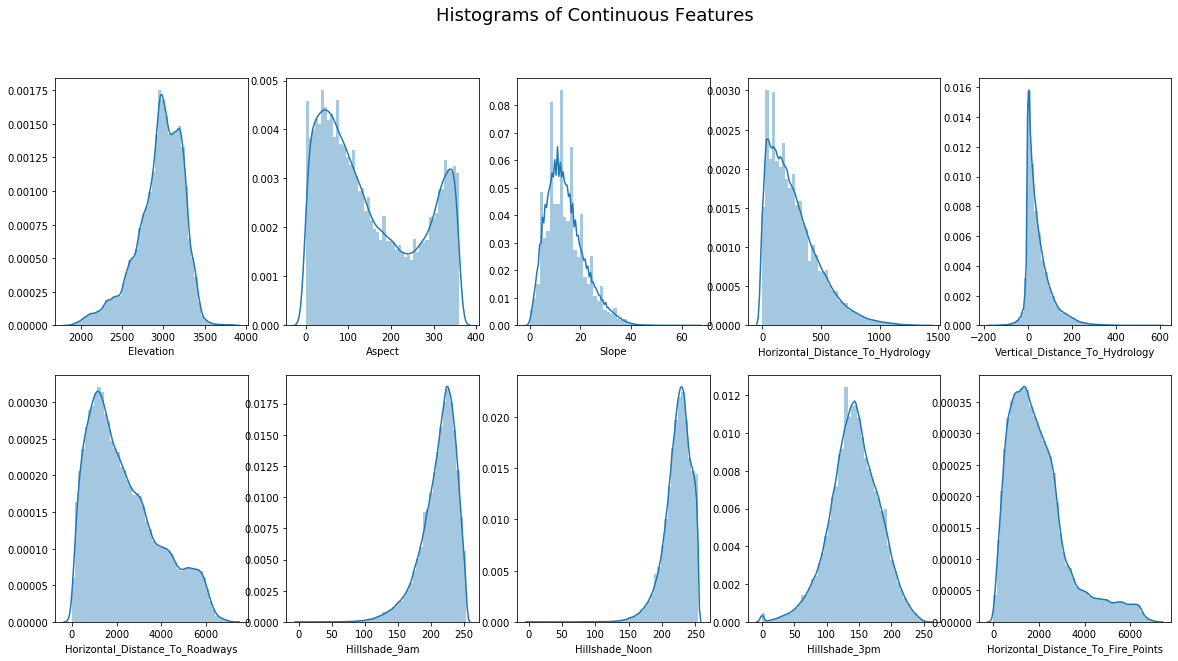

In [4]:
#plot the continuous data
fig, ax = plt.subplots(2, 5, figsize=(20,10))
continuous_data=raw_data.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points']

for i, col in enumerate(continuous_data.columns):
    sns.distplot(ax=ax[int(i/5),i%5],a=continuous_data[col])
    
plt.suptitle('Histograms of Continuous Features', fontsize=18)
plt.show()

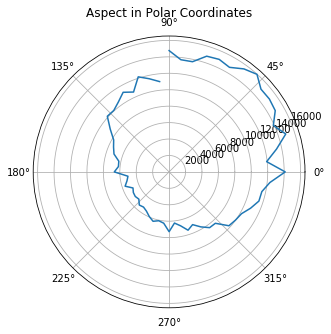

In [5]:
plt.figure(figsize=(15,5))
plt.polar((90-(np.histogram(raw_data["Aspect"], bins=60)[1][0:60]))*np.pi/180,
               np.histogram(raw_data["Aspect"], bins=60)[0][:60])
plt.title("Aspect in Polar Coordinates")
#plt.xticks([90*np.pi/180, 180*np.pi/180, 270*np.pi/180, 0*np,pi/180], ['N', 'W', 'S', 'E'])
#plt.xticks([0], ['E'])
plt.show()

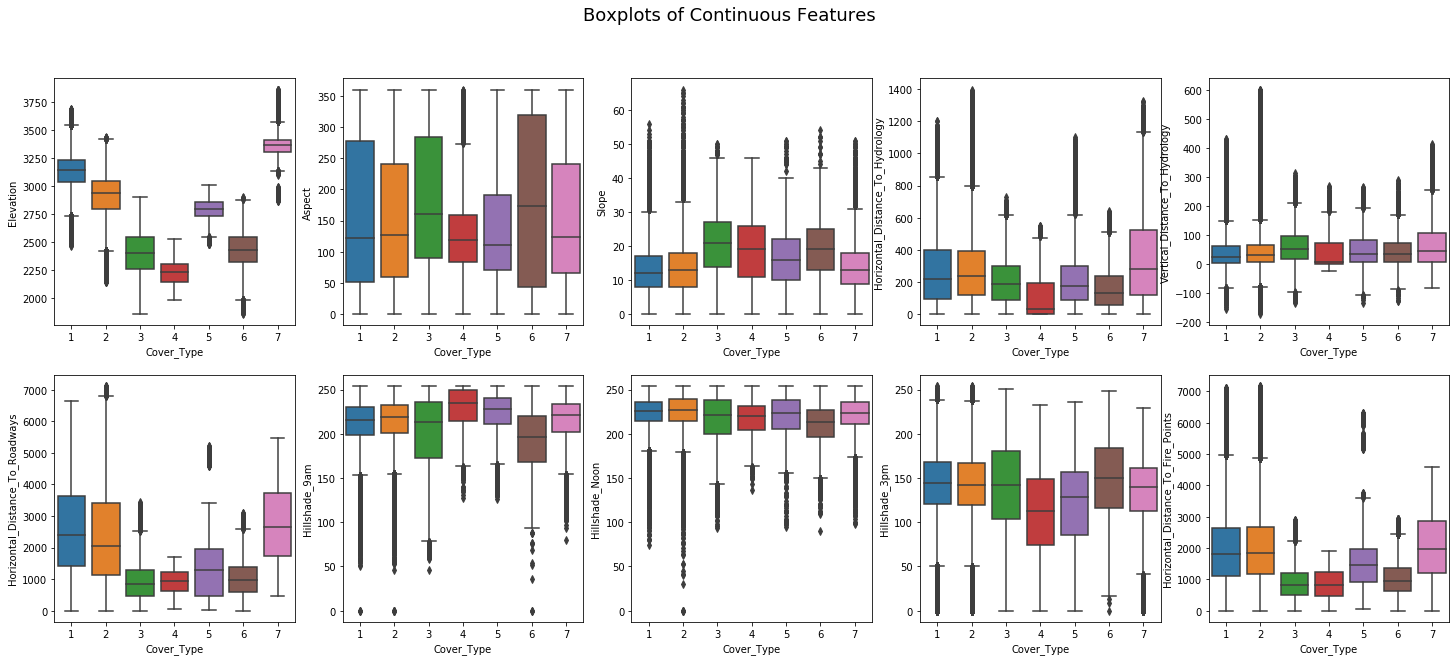

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))
raw_data['Cover_Type']=raw_data['Cover_Type'].astype('category') #To convert target class into category
for i, col in enumerate(continuous_data.columns):
    #plt.figure(i,figsize=(8,4))
    sns.boxplot(ax=ax[int(i/5),i%5], x=raw_data['Cover_Type'], y=col, data=raw_data)
    
plt.suptitle('Boxplots of Continuous Features', fontsize=18)
plt.show()